Maps and transportation networks are a natural fit for GNNs, since they’re basically graphs

* Nodes = intersections, bus stops, train stations…
* Edges = roads, railways, or routes.
* Features = traffic density, road type, average speed, bus frequency, etc.


Predicting Traffic on Roads on a city road network:

Each node = an intersection.
Each edge = a road segment between intersections.
Each node/edge has features like current traffic speed, number of lanes, or accidents reported.

The task: Given current traffic at time 𝑡, predict traffic at time 𝑡+1

Dataset

A famous benchmark is METR-LA (Los Angeles traffic sensors).
~200 sensors = nodes.

Edges = road connections.
Features = time series of traffic speed.

In [14]:
!pip's dependency resolver does not currently take into account all the packages that are installed.

!google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file
/bin/bash: line 1: google-colab: command not found


In [15]:
!pip install --upgrade torch-geometric-temporal
!pip install --upgrade pandas


In [23]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split

# 1. Dataset
loader = METRLADatasetLoader()
dataset = loader.get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

first_snapshot = next(iter(train_dataset))
print(f"x shape: {first_snapshot.x.shape}")
print(f"edge_index shape: {first_snapshot.edge_index.shape}")
print(f"edge_attr shape: {first_snapshot.edge_attr.shape if first_snapshot.edge_attr is not None else None}")
print(f"y shape: {first_snapshot.y.shape}")

NUM_NODES = first_snapshot.x.size(0)
WINDOW_SIZE = first_snapshot.x.size(1)
NUM_FEATURES = first_snapshot.x.size(2)

INPUT_FEATURES = WINDOW_SIZE * NUM_FEATURES


# 2. Modelo
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        self.gconvgru = GConvGRU(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h=None):
        if x.dim() == 3:  # (num_nodes, window, features)
            num_nodes, window_size, features = x.shape
            x = x.reshape(num_nodes, window_size * features)

        h = self.gconvgru(x, edge_index, edge_weight, h)
        return self.linear(h), h


# 3. Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentGCN(node_features=INPUT_FEATURES).to(device)  # ✅ ya funciona
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(5):
    total = 0.0
    count = 0
    h = None

    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        optimizer.zero_grad()

        y_hat, h = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h)
        h = h.detach()

        y = snapshot.y
        if y.dim() == 1:
            y = y.unsqueeze(-1)
        elif y.dim() == 2 and y.size(-1) != 1:
            y = y[..., :1]

        loss = F.mse_loss(y_hat, y)
        loss.backward()
        optimizer.step()

        total += loss.item()
        count += 1

    print(f"Epoch {epoch+1}, Loss: {total / max(count,1):.4f}")
#

x shape: torch.Size([207, 2, 12])
edge_index shape: torch.Size([2, 1722])
edge_attr shape: torch.Size([1722])
y shape: torch.Size([207, 12])
Epoch 1, Loss: 0.1488
Epoch 2, Loss: 0.1563
Epoch 3, Loss: 0.1479
Epoch 4, Loss: 0.1462
Epoch 5, Loss: 0.1417


Instead of predicting node 42’s speed just from its own past readings, the GNN uses:

Neighbors (nodes directly connected, i.e. nearby intersections).
Neighbors of neighbors (traffic upstream/downstream).
Time (past sequence of readings).

This way, if there’s a slowdown 2 blocks away, the model can learn to anticipate that it will affect node 42 soon.

Predicting one specific node, suppose node 42 is your target location (maybe a speed sensor near a highway).

In [32]:
model.eval()
with torch.no_grad():
    total = 0.0
    count = 0
    h = None

    for snapshot in test_dataset:
        snapshot = snapshot.to(device)

        y_hat, h = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h)

        y = snapshot.y
        if y.dim() == 1:
            y = y.unsqueeze(-1)
        elif y.dim() == 2 and y.size(-1) != 1:
            y = y[..., :1]

        total += F.mse_loss(y_hat, y).item()
        count += 1

    print(f"Test MSE: {total / max(count,1):.4f}")


Test MSE: 1.4405


# **EJERCICIO 2**

1. If you were training on a small dataset (like only 1 week of traffic speeds), would you pick a smaller or larger hidden size? Why do you think so?
2. What is that 32 magic number? what if you change it to 16 what happened if to 64?
   

# **Soluciòn**

1. Elegiría un tamaño oculto más pequeño, por ejemplo 16 en lugar de 32 o 64.
La razón es que un conjunto de datos pequeño contiene menos información para entrenar un modelo grande, por lo que un tamaño oculto alto puede provocar sobreajuste (overfitting).
Un modelo con menos parámetros (menor dimensión oculta) tiende a aprender patrones más generales y se ajusta mejor cuando los datos son limitados.

2. El número 32 es un hiperparámetro que define la dimensión oculta del modelo, es decir, el tamaño del vector interno donde se representa la información de cada nodo a lo largo del tiempo.
Este valor controla la capacidad del modelo para aprender patrones espaciales y temporales:

- Si se aumenta a 64, el modelo puede aprender relaciones más complejas, pero también tiene mayor riesgo de sobreajuste.

- Si se reduce a 16, el modelo será más rápido y generalizará mejor, aunque podría perder capacidad de representación.

# **Modelo con  16**

In [38]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split
from tqdm import tqdm  # solo para barra de progreso visual

# ==============================
# 1. Cargar dataset
# ==============================
loader = METRLADatasetLoader()
dataset = loader.get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

first_snapshot = next(iter(train_dataset))
print(f"x shape: {first_snapshot.x.shape}")
print(f"edge_index shape: {first_snapshot.edge_index.shape}")
print(f"edge_attr shape: {first_snapshot.edge_attr.shape if first_snapshot.edge_attr is not None else None}")
print(f"y shape: {first_snapshot.y.shape}")

NUM_NODES = first_snapshot.x.size(0)
WINDOW_SIZE = first_snapshot.x.size(1)
NUM_FEATURES = first_snapshot.x.size(2)
INPUT_FEATURES = WINDOW_SIZE * NUM_FEATURES

# ==============================
# 2. Modelo
# ==============================
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        self.gconvgru = GConvGRU(node_features, 16, 1)
        self.linear = torch.nn.Linear(16, 1)

    def forward(self, x, edge_index, edge_weight, h=None):
        # Mantener mismo aplanamiento que el original
        if x.dim() == 3:
            num_nodes, window_size, features = x.shape
            x = x.reshape(num_nodes, window_size * features)
        h = self.gconvgru(x, edge_index, edge_weight, h)
        return self.linear(h), h

# ==============================
# 3. Entrenamiento
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentGCN(node_features=INPUT_FEATURES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # mismo que el original

model.train()
for epoch in range(5):  # mismo número de epochs
    total_loss = 0.0
    count = 0
    h = None

    for snapshot in tqdm(train_dataset, desc=f"Epoch {epoch+1}", leave=False):
        snapshot = snapshot.to(device)
        optimizer.zero_grad()

        y_hat, h = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h)
        h = h.detach()

        y = snapshot.y
        if y.dim() == 1:
            y = y.unsqueeze(-1)
        elif y.dim() == 2 and y.size(-1) != 1:
            y = y[..., :1]

        loss = F.mse_loss(y_hat, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1

    print(f"Epoch {epoch+1}, Loss: {total_loss / max(count,1):.4f}")

# ==============================
# 4. Evaluación
# ==============================
model.eval()
with torch.no_grad():
    total_loss = 0.0
    count = 0
    h = None

    for snapshot in tqdm(test_dataset, desc="Testing"):
        snapshot = snapshot.to(device)

        y_hat, h = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h)

        y = snapshot.y
        if y.dim() == 1:
            y = y.unsqueeze(-1)
        elif y.dim() == 2 and y.size(-1) != 1:
            y = y[..., :1]

        total_loss += F.mse_loss(y_hat, y).item()
        count += 1

    print(f"\nTest MSE: {total_loss / max(count,1):.4f}")


x shape: torch.Size([207, 2, 12])
edge_index shape: torch.Size([2, 1722])
edge_attr shape: torch.Size([1722])
y shape: torch.Size([207, 12])


Epoch 1, Loss: 0.1390


Epoch 2, Loss: 0.1377


Epoch 3, Loss: 0.1311


Epoch 4, Loss: 0.1331


Epoch 5, Loss: 0.1291


Testing: 6850it [00:33, 206.15it/s]


Test MSE: 0.6857


# **Modelo con  64**

In [39]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split
from tqdm import tqdm  # solo para barra de progreso visual

# ==============================
# 1. Cargar dataset
# ==============================
loader = METRLADatasetLoader()
dataset = loader.get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

first_snapshot = next(iter(train_dataset))
print(f"x shape: {first_snapshot.x.shape}")
print(f"edge_index shape: {first_snapshot.edge_index.shape}")
print(f"edge_attr shape: {first_snapshot.edge_attr.shape if first_snapshot.edge_attr is not None else None}")
print(f"y shape: {first_snapshot.y.shape}")

NUM_NODES = first_snapshot.x.size(0)
WINDOW_SIZE = first_snapshot.x.size(1)
NUM_FEATURES = first_snapshot.x.size(2)
INPUT_FEATURES = WINDOW_SIZE * NUM_FEATURES

# ==============================
# 2. Modelo
# ==============================
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super().__init__()
        self.gconvgru = GConvGRU(node_features, 64, 1)
        self.linear = torch.nn.Linear(64, 1)

    def forward(self, x, edge_index, edge_weight, h=None):
        # Mantener mismo aplanamiento que el original
        if x.dim() == 3:
            num_nodes, window_size, features = x.shape
            x = x.reshape(num_nodes, window_size * features)
        h = self.gconvgru(x, edge_index, edge_weight, h)
        return self.linear(h), h

# ==============================
# 3. Entrenamiento
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentGCN(node_features=INPUT_FEATURES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # mismo que el original

model.train()
for epoch in range(5):  # mismo número de epochs
    total_loss = 0.0
    count = 0
    h = None

    for snapshot in tqdm(train_dataset, desc=f"Epoch {epoch+1}", leave=False):
        snapshot = snapshot.to(device)
        optimizer.zero_grad()

        y_hat, h = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h)
        h = h.detach()

        y = snapshot.y
        if y.dim() == 1:
            y = y.unsqueeze(-1)
        elif y.dim() == 2 and y.size(-1) != 1:
            y = y[..., :1]

        loss = F.mse_loss(y_hat, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        count += 1

    print(f"Epoch {epoch+1}, Loss: {total_loss / max(count,1):.4f}")

# ==============================
# 4. Evaluación
# ==============================
model.eval()
with torch.no_grad():
    total_loss = 0.0
    count = 0
    h = None

    for snapshot in tqdm(test_dataset, desc="Testing"):
        snapshot = snapshot.to(device)

        y_hat, h = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h)

        y = snapshot.y
        if y.dim() == 1:
            y = y.unsqueeze(-1)
        elif y.dim() == 2 and y.size(-1) != 1:
            y = y[..., :1]

        total_loss += F.mse_loss(y_hat, y).item()
        count += 1

    print(f"\nTest MSE: {total_loss / max(count,1):.4f}")


x shape: torch.Size([207, 2, 12])
edge_index shape: torch.Size([2, 1722])
edge_attr shape: torch.Size([1722])
y shape: torch.Size([207, 12])


Epoch 1, Loss: 0.1824


Epoch 2, Loss: 0.1730


Epoch 3, Loss: 0.1709


Epoch 4, Loss: 0.1783


Epoch 5, Loss: 0.1818


Testing: 6850it [00:37, 180.97it/s]


Test MSE: 2.4474


In [40]:
# Example: Node Classification on Cora

# train a Graph Convolutional Network (GCN):

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# Load dataset (Cora graph)
# Load the Cora dataset (2708 papers, 5429 citation links)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Train a 2-layer GCN to classify papers into research topics.
# Define a simple 2-layer GCN
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model and optimizer
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Test accuracy
# test accuracy around 80%+ after training
model.eval()
pred = out.argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')


Processing...
Done!


Accuracy: 0.7580


# **Ejercicio 2**

- Graph metric and report
- use more GCN layers and report

=== Graph Metrics ===
Number of nodes: 2708
Number of edges: 10556
Average degree: 3.90
Density: 0.0029
Number of classes: 7
Class distribution: tensor([351, 217, 418, 818, 426, 298, 180])



100%|██████████| 200/200 [00:09<00:00, 20.76it/s]



=== Test Report ===
Test Accuracy: 0.7360
Test F1 Score: 0.7355
Test Precision: 0.7164
Test Recall: 0.7709


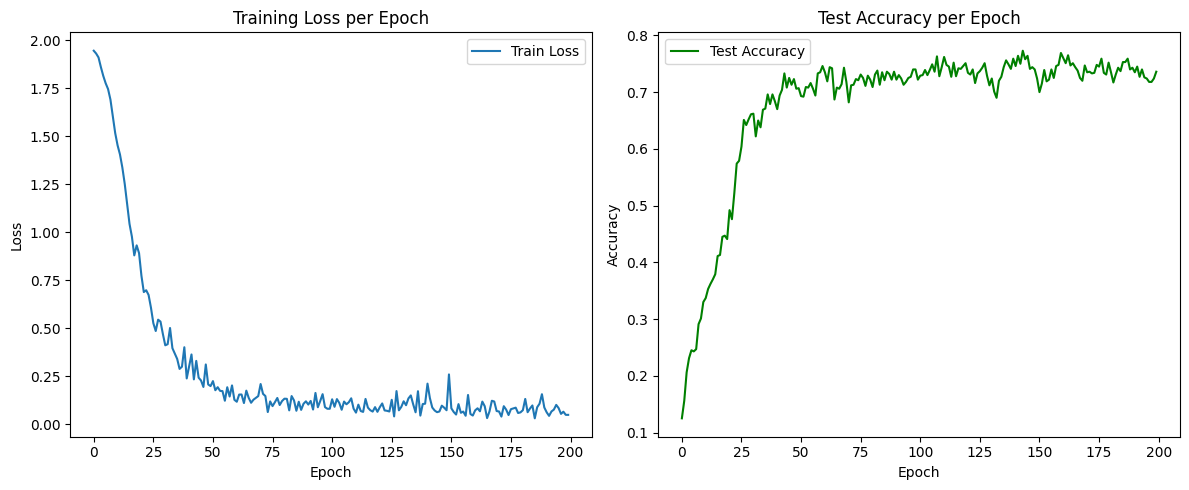

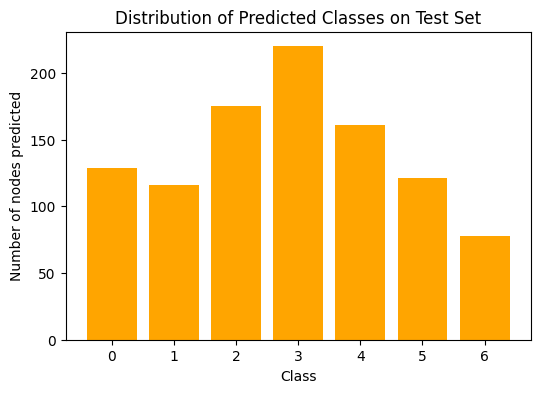

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import degree
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 1. Cargar dataset
# ==========================
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# ==========================
# 2. Métricas del grafo
# ==========================
num_nodes = data.num_nodes
num_edges = data.num_edges
deg = degree(data.edge_index[0], num_nodes=num_nodes)
avg_degree = deg.mean().item()
density = 2*num_edges / (num_nodes*(num_nodes-1))

print("=== Graph Metrics ===")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Density: {density:.4f}")
print(f"Number of classes: {dataset.num_classes}")
print("Class distribution:", torch.bincount(data.y))
print("=====================\n")

# ==========================
# 3. Definir GCN de 4 capas
# ==========================
class GCN4Layers(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

# ==========================
# 4. Inicializar modelo
# ==========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN4Layers(dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# ==========================
# 5. Entrenamiento y registro de métricas por epoch
# ==========================
epochs = 200
train_losses = []
test_accuracies = []

for epoch in tqdm(range(epochs)):
    # entrenamiento
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # evaluación test
    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
        acc = correct / int(data.test_mask.sum())
        test_accuracies.append(acc)

# ==========================
# 6. Reporte final métricas
# ==========================
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / int(data.test_mask.sum())
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print("\n=== Test Report ===")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print("===================")

# ==========================
# 7. Graficar resultados
# ==========================
plt.figure(figsize=(12,5))

# Loss por epoch
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()

# Accuracy por epoch
plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Histograma de predicciones
plt.figure(figsize=(6,4))
plt.hist(y_pred, bins=np.arange(dataset.num_classes+1)-0.5, rwidth=0.8, color='orange')
plt.xticks(range(dataset.num_classes))
plt.xlabel("Class")
plt.ylabel("Number of nodes predicted")
plt.title("Distribution of Predicted Classes on Test Set")
plt.show()
